## Example ODE with custom library

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the a non-linear ODE

We start by importing the required DeepMoD functions:

In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions


from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat


import torch
from torch.autograd import grad
from itertools import combinations
from functools import reduce
from typing import Tuple
from deepymod.utils.types import TensorList
from deepymod import Library

from scipy.integrate import odeint

# Settings for reproducibility
np.random.seed(40)
torch.manual_seed(0)

# Configuring GPU or CPU
if  torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

D:\PycharmProjects\DeePyMoD\src\deepymod\__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


cuda


We check where the package is located

In [2]:
import deepymod as dpm

dpm

<module 'deepymod' from 'D:\\PycharmProjects\\DeePyMoD\\src\\deepymod\\__init__.py'>

# Preparing the dataset
Firstly we prepare the dataset. The set of ODEs we consider here are
$d[y, z]/dt = [z, -z- 5 \sin y]$

In [3]:
def dU_dt_true(U):
    """
    returns the right hand side of the differential equation"""
    return [U[1], -1 * U[1] - 5 * np.sin(U[0])]


def dU_dt_sin(U, t):
    """
    returns the right hand side of the differential equation"""
    return dU_dt_true(U)

We then define a function that solves the ODE and then ensures that 
both coordinates and data get a shape of n_samples x feature and
be returned as (coordinate, data)

In [4]:
def create_data(U0=np.array([2.5, 0.4]), ts=np.linspace(0, 8, 500)):
    """
    Creates data which is the solution of the simple ODE system example.
    the output has torch.float32 format.

    Args:
        U0: Initial condition
        ts: Time points to evaluate the ODE at.
    """
    Y = torch.from_numpy(odeint(dU_dt_sin, U0, ts)).float()
    T = torch.from_numpy(ts.reshape(-1, 1)).float()
    return T, Y

Thus we take unnormalized but also randomly subsample the data applying small amound of noise:

Preprocessing data
Dataset is using device:  cuda


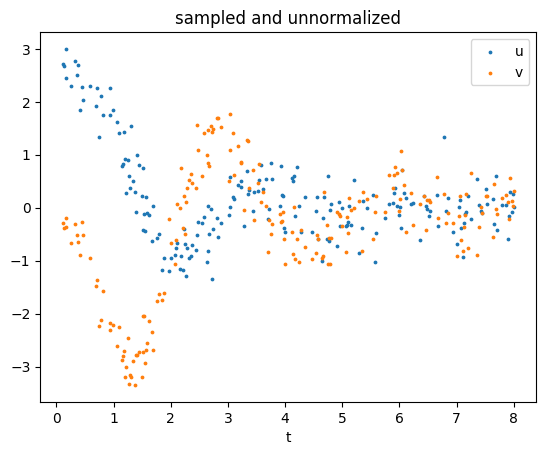

In [5]:
dataset = Dataset(
    create_data,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 200},
    preprocess_kwargs={
        "noise_level": 0.4,
    },
    device=device,
)
dataset.data.shape
fig, ax = plt.subplots()
ax.scatter(dataset.coords.cpu(), dataset.data[:, 0].cpu(), label="u", s=3)
ax.scatter(dataset.coords.cpu(), dataset.data[:, 1].cpu(), label="v", s=3)
ax.set_xlabel("t")
ax.legend()
ax.set_title("sampled and unnormalized")
plt.show()

Now we need to split our data into a train and test dataloaders for PyTorch

In [6]:
# see deepymod.data.base.get_train_test_loader for definition of `get_train_test_loader` function.
# the shuffle is completely random mixing latter and earlier times
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

# Setup a custom library

In this notebook we show how the user can create a custom build library.The library function, $\theta$, in this case contains $[1,u,v, cos(u), sin(u)]$ to showcase that non-linear terms can easily be added to the library

In [7]:
from torch.autograd import grad
from itertools import combinations, product
from functools import reduce


class Library_nonlinear(Library):  # see: deepymod.model.deepmod.Library
    """[summary]

    Args:
        Library ([type]): [description]
    """

    def __init__(self) -> None:
        super().__init__()

    def library(
        self, input: Tuple[torch.Tensor, torch.Tensor]
    ) -> Tuple[TensorList, TensorList]:
        prediction, data = input
        samples = prediction.shape[0]
        poly_list = []
        deriv_list = []
        time_deriv_list = []
        # Construct the theta matrix
        C = torch.ones_like(prediction[:, 0]).view(samples, -1)  # constant of ones
        u = prediction[:, 0].view(samples, -1)  # a term proportional to u
        v = prediction[:, 1].view(samples, -1)  # a term proportional to v
        theta = torch.cat(
            (C, u, v, torch.cos(u), torch.sin(u)), dim=1
        )  # a term porportional to sin(u)
        # Construct a list of time_derivatives
        time_deriv_list = []
        for output in torch.arange(prediction.shape[1]):
            dy = grad(
                prediction[:, output],
                data,
                grad_outputs=torch.ones_like(prediction[:, output]),
                create_graph=True,
            )[0]
            time_deriv = dy[:, 0:1]
            time_deriv_list.append(time_deriv)
        return time_deriv_list, [theta, theta]

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.

In [8]:
network = NN(1, [30, 30, 30, 30], 2)
library = Library_nonlinear()
estimator = Threshold(0.1)
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5)
constraint = LeastSquares()
model = DeepMoD(network, library, estimator, constraint)  # .to(device)
model.to(device)
optimizer = torch.optim.Adam(
    model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=5e-3
)
model

DeepMoD(
  (func_approx): NN(
    (network): Sequential(
      (0): Linear(in_features=1, out_features=30, bias=True)
      (1): Tanh()
      (2): Linear(in_features=30, out_features=30, bias=True)
      (3): Tanh()
      (4): Linear(in_features=30, out_features=30, bias=True)
      (5): Tanh()
      (6): Linear(in_features=30, out_features=30, bias=True)
      (7): Tanh()
      (8): Linear(in_features=30, out_features=2, bias=True)
    )
  )
  (library): Library_nonlinear()
  (sparse_estimator): Threshold()
  (constraint): LeastSquares()
)

## Run DeepMoD

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [9]:
%%time
! rm -rf ./data/deepymod/ODE_2DOF_sparsity/
foldername = "./data/deepymod/ODE_2DOF_sparsity/"
train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    log_dir=foldername,
    max_iterations=100000,
    delta=1e-3,
    patience=100,
)

  5975  MSE: 2.66e-01  Reg: 6.23e-03  L1: 2.82e+00 Algorithm converged. Writing model to disk.
CPU times: total: 17min 41s
Wall time: 1min 25s


The developers have created a routine to deal with tensorboard logging. We can load the output to pandas!

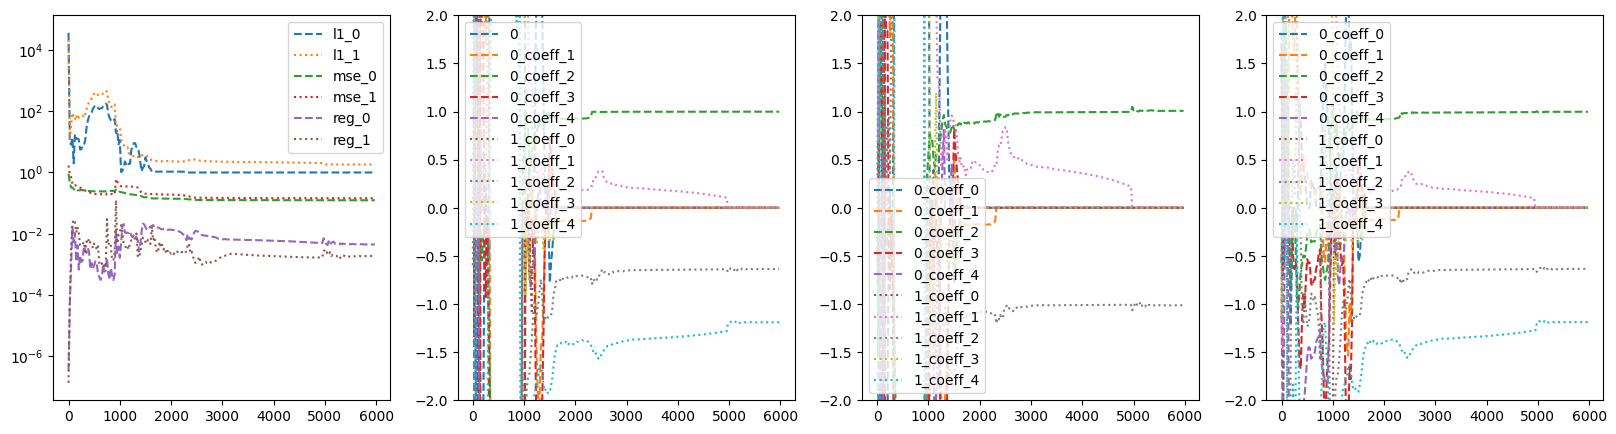

In [19]:
from deepymod.analysis import load_tensorboard

history = load_tensorboard(foldername)
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for history_key in history.keys():
    history_key_parts = history_key.split("_")
    if history_key_parts[0] == "loss":
        if history_key_parts[-1] == "0":
            axs[0].semilogy(
                history[history_key],
                label=history_key_parts[1] + "_" + history_key_parts[-1],
                linestyle="--",
            )
        elif history_key_parts[-1] == "1":
            axs[0].semilogy(
                history[history_key],
                label=history_key_parts[1] + "_" + history_key_parts[-1],
                linestyle=":",
            )
        else:
            axs[0].semilogy(
                history[history_key],
                label=history_key_parts[1] + "_" + history_key_parts[-1],
                linestyle="-",
            )
        if history_key_parts[0] == "remaining":
            axs[0].semilogy(
                history[history_key],
                label=history_key_parts[1]
                + "_"
                + history_key_parts[3]
                + "_"
                + history_key_parts[4],
                linestyle="-.",
            )
    if history_key_parts[0] == "coeffs":
        if len(history_key_parts) >= 5:
            label_str = f"{history_key_parts[2]}_{history_key_parts[3]}_{history_key_parts[4]}"
        else:
            label_str = "_".join(history_key_parts[2:])
        if len(history_key_parts) > 2:
            if history_key_parts[2] == "0":
                axs[1].plot(history[history_key], label=label_str, linestyle="--")
            elif history_key_parts[2] == "1":
                axs[1].plot(history[history_key], label=label_str, linestyle=":")
            else:
                axs[1].plot(history[history_key], label=label_str, linestyle="-")
    if history_key_parts[0] == "unscaled":
        if history_key_parts[3] == "0":
            axs[2].plot(
                history[history_key],
                label=history_key_parts[3]
                + "_"
                + history_key_parts[4]
                + "_"
                + history_key_parts[5],
                linestyle="--",
            )
        elif history_key_parts[3] == "1":
            axs[2].plot(
                history[history_key],
                label=history_key_parts[3]
                + "_"
                + history_key_parts[4]
                + "_"
                + history_key_parts[5],
                linestyle=":",
            )
        else:
            axs[2].plot(
                history[history_key],
                label=history_key_parts[3]
                + "_"
                + history_key_parts[4]
                + "_"
                + history_key_parts[5],
                linestyle="-",
            )
    if history_key_parts[0] == "estimator":
        if history_key_parts[3] == "0":
            axs[3].plot(
                history[history_key],
                label=history_key_parts[3]
                + "_"
                + history_key_parts[4]
                + "_"
                + history_key_parts[5],
                linestyle="--",
            )
        elif history_key_parts[3] == "1":
            axs[3].plot(
                history[history_key],
                label=history_key_parts[3]
                + "_"
                + history_key_parts[4]
                + "_"
                + history_key_parts[5],
                linestyle=":",
            )
        else:
            axs[3].plot(
                history[history_key],
                label=history_key_parts[3]
                + "_"
                + history_key_parts[4]
                + "_"
                + history_key_parts[5],
                linestyle="-",
            )

# axs[0].set_ylim([-2, 2])
axs[1].set_ylim([-2, 2])
axs[2].set_ylim([-2, 2])
axs[3].set_ylim([-2, 2])

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

plt.show()

Now that DeepMoD has converged, it has found the following coefficients to not be zero: 

In [13]:
model.sparsity_masks

[tensor([False, False,  True, False, False], device='cuda:0'),
 tensor([False, False,  True, False,  True], device='cuda:0')]

And it found the following coefficients.

In [14]:
model.constraint_coeffs()

[tensor([[0.0000],
         [0.0000],
         [1.0071],
         [0.0000],
         [0.0000]], device='cuda:0', grad_fn=<MaskedScatterBackward0>),
 tensor([[ 0.0000],
         [ 0.0000],
         [-1.0131],
         [ 0.0000],
         [-4.9906]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]

We can reconstruct the equations from this:

In [15]:
library = ["1", "u", "v", "cos(u)", "sin(u)"]
ders = ["u_t", "v_t"]
for sparse, coeff_vector, der in zip(
    model.sparsity_masks, model.constraint_coeffs(), ders
):
    expression = ""
    coeffs = [
        "%.5f" % number for number in (coeff_vector.detach().cpu().numpy().squeeze())
    ]
    monomials = [str(a) + "*" + str(b) for a, b in zip(coeffs, library)]
    sparse_array = sparse.detach().cpu().numpy()
    print(der, "=", np.extract(sparse_array, monomials))
    # for sparse_element, coeff in zip(sparse.detach().cpu().numpy(),coeff_vector.detach().cpu().numpy()):
    #    expression += ' +'+str(coeff)+library[sparse_element]
    # print(der,' =',expression, '\t')

u_t = ['1.00713*v']
v_t = ['-1.01307*v' '-4.99063*sin(u)']


The output of the model is trained to reproduce the PDE output

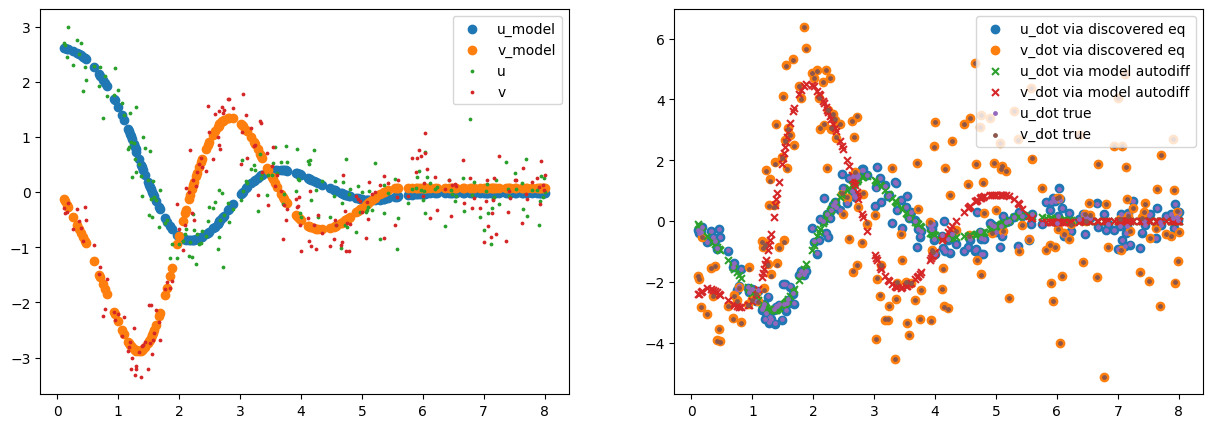

In [22]:
coords_cpu = dataset.coords.detach().cpu().numpy()

def dU_dt_estimate(U):
    TH = [1, U[0], U[1], np.cos(U[0]), np.sin(U[0])]
    output = []
    for sparse, coeff_vector, der in zip(
        model.sparsity_masks, model.constraint_coeffs(), ders
    ):
        coeffs = coeff_vector.detach().cpu().numpy().squeeze()
        output.append(np.sum(sparse.detach().cpu().numpy() * coeffs * TH))
    return output

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# subfigure 1
axs[0].scatter(
    coords_cpu, # 修改处
    model(dataset.coords)[0][:, 0].detach().cpu().numpy(),
    label="u_model",
)
axs[0].scatter(
    coords_cpu, # 修改处
    model(dataset.coords)[0][:, 1].detach().cpu().numpy(),
    label="v_model",
)
axs[0].scatter(coords_cpu, dataset.data[:, 0].detach().cpu().numpy(), label="u", s=3) # 修改处
axs[0].scatter(coords_cpu, dataset.data[:, 1].detach().cpu().numpy(), label="v", s=3) # 修改处
axs[0].legend()

# subfigure 2
deriv_eq_estimate = np.array(
    list(map(dU_dt_estimate, dataset.data.detach().cpu().numpy()))
)
deriv_eq_true = np.array(list(map(dU_dt_true, dataset.data.detach().cpu().numpy())))

axs[1].scatter(coords_cpu, deriv_eq_estimate[:, 0], label="u_dot via discovered eq") # 修改处
axs[1].scatter(coords_cpu, deriv_eq_estimate[:, 1], label="v_dot via discovered eq") # 修改处

axs[1].scatter(
    coords_cpu, # 修改处
    model(dataset.coords)[1][0].detach().cpu().numpy(),
    label="u_dot via model autodiff",
    marker="x",
    s=25,
)
axs[1].scatter(
    coords_cpu, # 修改处
    model(dataset.coords)[1][1].detach().cpu().numpy(),
    label="v_dot via model autodiff",
    marker="x",
    s=25,
)

axs[1].scatter(coords_cpu, deriv_eq_true[:, 0], label="u_dot true", marker="o", s=6) # 修改处
axs[1].scatter(coords_cpu, deriv_eq_true[:, 1], label="v_dot true", marker="o", s=6) # 修改处

axs[1].legend()

plt.show()